I've been building or tinkering with data visualization ideas in Python for a while now, both in my free time and in my (still nascent) professional work. The Python data visualization ecosystem is incredibly diverse&mdash;Jake VanderPlas dedicated an entire PyCon 2017 talk, ["The Python Data Visualization Ecosystem"](https://www.youtube.com/watch?v=FytuB8nFHPQ), to counting out a representative subset of 36 libraries.

In this post I will share some of the most influential ideas I have seen in data visualization API design. Technically speaking, an **API** is the set of tools that a programmer uses to build programs with a software module or product. A good API makes a module easy and fun. A poor one can make even the most technically innovative product a drag. Note that this post is not an opinion on the libraries themselves, but a look at some major interface design ideas that these libraries have implemented, and what they can and can't achieve for the user.

## User and audience comprehension

To start things off, let's discuss some general data visualization philosophy.

The objective of a data visualization library is some combination of just two things: user comprehension, and audience comprehension. These two tasks are fundamentally different.

User comprehension is the ability of the individual building the visualization to understand some interesting feature of the dataset. What constitutes interesting obviously varies, but the broad theme is: tell me something about this dataset that I couldn't learn by with a table alone. User comprehension is performed by a data analyst.

Audience comprehension, by contrast, is the ability of users besides the individual doing the visualization to understand interesting features. In this case, the objective to maximize is how well the visualization communicates the desired information to a target audience. Audience comprehension is performed by a data presenter.

Data analysts are generally spending valuable time resources to visualize. They are willing to spend more time interpreting a more complicated visualization result, so long as the visualizations they build are relatively easy-to-make. This leads to a strong preference for expedient solutions and reusable templates.

Data presenters by contrast are generally presenting their work to an external audience, one less experienced that the analyst building the graphic at visual interpretation. Good data presenters are more willing to accept harder-to-build visualizations, if that means more easily interpretable results.

An example of a highly data analysis specific task would be optimizing a machine learning model. In this setting it is very important to have a deep understanding of every aspect of the dataset, as this understanding is fundamental to the approach you take and the performance you ultimately get from the result. An ML practitioner invariably builds heaps of short-lived, messy-looking charts, none of which survive long enough to be seen by anyone else. These often look like this:

![](http://www.scikit-yb.org/en/latest/_images/spam_discrimination_threshold.png)

Interpreting this graph takes heaps of domain knowledge, experience with this plot type, and knowledge about the dataset being visualized; all things highly specific to the person creating the chart. But actually creating it is easy. You just feed two lists of data to a template and get a result.

An example of a highly data presentation specific task, by contrast, is data journalism. In data journalism you are attempting to communicate some story of viewpoint to a public audience. The public audience is visually uninformed, and has a very low threshold for interpretive complexity, so good data journalists must be skilled in using sophisticated tools to build highly custom "data experiences". An extreme example is this New York Times visualization of collaborations amongst Oscar winners:

![](https://static01.nyt.com/images/2013/02/21/movies/awardsseason/21oscar-network-sf-image/21oscar-network-sf-image-superJumbo.png)

This visualization is algorithmically complex; it apparently required its own layout engine, discussed briefly [here](https://bost.ocks.org/mike/example/) to work at all. But the result is beautifully easy to interpret.

All data visualization tasks lie on the a spectrum between these two extremes. Tools that are great for data presentation tend to be very complicated and low-level, but also as a consequence very feature-rich and customizable; tools that are great for data analysis are easy-to-use but offer limited tweaking. For a data visualization module designer, the trick is to strike an appealing balance: between easy-to-use and easy-to-customize, between simple and complex, between limiting and expressive.

In the next few sections we'll look at four major API features data visualization library authors have implemented for striking this balance.

## Abstraction stacks

In computer science an **abstraction** is a self-contained system that hides complexity from its user. The Python `requests` library, reputed for having a particularly beautiful API, is an abstraction that builds on `httplib` and friends to make network requests intuitive. CPython is an abstraction that keeps you from having to write machine code. And so on.

But sometimes we need to leave the current abstraction and dig deeper. This occurs when there is something we need that the current abstraction level does not support. It's impossible to come up with an API that covers every possible usecase, and well-designed data visualization libraries don't even try. Instead, to handle this need, mature Python data visualization tools provide easy access to their abstraction stack.

I will use `matplotlib` to demonstrate what I mean. `matplotlib` is the oldest and most heavily utilized Python data visualization library, featuring an initial release date way back in 2003. `matplotlib` provides, at the highest level, **charts**. It's important to realize that charts, e.g. things like bar charts and scatter plots and the like, are abstractions: data comes in, a well-defined image template processes the input, and a bunch of pixels arranged in a familiar (or unfamiliar) shape comes out.

For example, here is one the simplest chart types in action&mdash;the bar chart:

<BarContainer object of 3 artists>

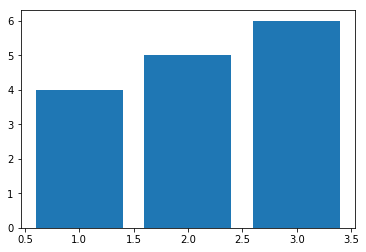

In [19]:
import matplotlib.pyplot as plt
plt.bar([1, 2, 3], [4, 5, 6])

Charts are a great abstraction because they're simple, yet powerful. To get output all you need to do is provide a couple of lists of data, and the output intrinsically "makes sense". And if our bar chart doesn't make sense, then we have a good sense of what we need to do to debug it.

If we needed to tweak this plot in some non-trivial way, and all `matplotlib` provided us with was `plt.bar`, we'd be stuck; but luckily it also allows us to go lower-level.

Every element of a chart is just a geometry of some kind. A scatter plot consists of many points, a line chart of line segments, and a bar chart of rectangles. Using this lower level of abstraction, **geometry**, we can easily replicate this chart by drawing rectangles on the screen.

(0, 6.5)

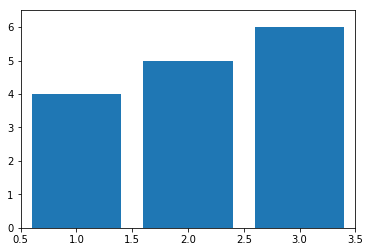

In [84]:
from matplotlib.patches import Rectangle

ax = plt.gca()
ax.add_patch(Rectangle((0.6, 0), 0.8, 4))
ax.add_patch(Rectangle((1.6, 0), 0.8, 5))
ax.add_patch(Rectangle((2.6, 0), 0.8, 6))
ax.set_xlim([0.5, 3.5])
ax.set_ylim([0, 6.5])

This way of plotting is more powerful and expressive, but also obviously significantly more complex. The naive bar chart required practically no knowledge about how `matplotlib` works. Plotting using geometries requires knowing what an `axis` is, that you can get the current `matplotlib` `axis` objects using `plt.gca()`, and that there is a `Rectangle` element that can be appended using `ax.add_patch`.

Most data visualization libraries are, on some level, organized around charts. Charts are easy to understand, easy to work with, and easy to remember. They're a great abstraction!

A plurality of data visualization libraries in Python are built on top of `matplotlib`. Those libraries that do so have a standardized "abstraction escape hatch": when you create a plot, you are automatically returned a reference to the underlying `matplotlib` `axis` object. Here's a demo, using the `seaborn` library:

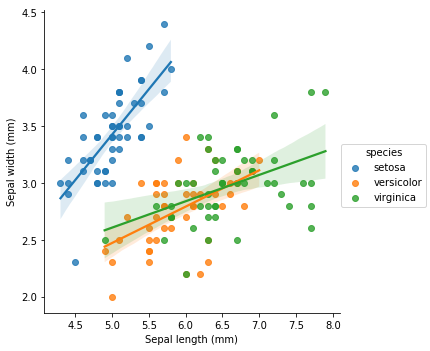

In [88]:
import seaborn as sns
iris = sns.load_dataset("iris")

# Create a plot and catch the axis.
ax = sns.lmplot(x="sepal_length", y="sepal_width", hue="species",
                truncate=True, size=5, data=iris)

# Modify the axis.
ax.set_axis_labels("Sepal length (mm)", "Sepal width (mm)")

An abstraction stack is just about a hard requirement&mdash;every major data visualization library in Python has one. That's because it enables the best of both worlds: simple chart-based APIs for the 90% use-case, and a fallback for those remaining 10% of plots that you really want looking spiffy.

## State machines

Most data visualization library APIs are **object-oriented**. In object-oriented programming inputs and outputs are modeled as objects, and the resulting programs operate by hanging functions off of these objects.

Object-oriented data visualization can be thought of as a two-step process. First, use an object instantiation method to generate a chart or scene. Then, call functions hanging off the object to "paint" on desired features:

```python
    chart = Chart()
    chart.do_something()
    chart.do_something_else()
    chart.display()
```

An object-oriented API is a safe, well-understood choice, and data visualization library authors are not usually interested in novel interface design. OO API designs are ubiquitious because OO itself is ubiquitious.

Here is a `matplotlib` demonstration of OO in action:

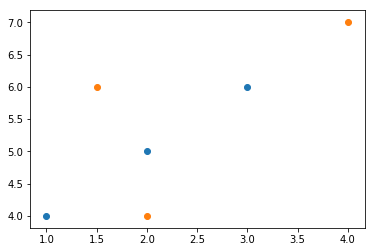

In [110]:
# Initialize a figure with a list of two axis objects.
ax = plt.subplot(111)

ax.scatter([1,2,3],[4,5,6])
ax.scatter([1.5,2,4],[6,4,7])

We begin by initializing an `Axis` object, assinging that object to the `ax` variable. Then we call `Axis.scatter` object methods to paint our chart in two steps.

However, `matplotlib` inherited its API design and overall style from the plotting facilities in the venerable MATLAB programming language. One of the features that got carried over is schizophrenia&mdash;`matplotlib` comes equipped with both an object-oriented API and a **state machine** one. A **state machine** is a software design pattern that differs from pure OO in that it "remembers" the current state of the visualization. We do not have to reference the underlying object to make changes to it, but we do have to remember where we are in the scene. Here's a demonstration using the `matplotlib` state machine:

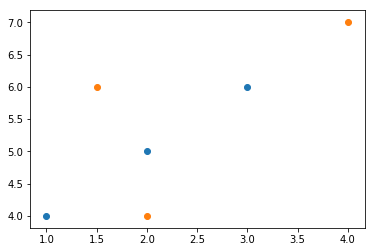

In [112]:
ax = plt.gca()
plt.scatter([1,2,3],[4,5,6])
plt.scatter([1.5,2,4],[6,4,7])

We started the plot off by asking for the current axis instance with `plt.gca` ("get current axis"). This causes the `matplotlib` state machine to get the most "recent" plot axis. In fact, since none exist yet, it goes ahead and creates one for you! We then plot two different datasets onto the axis using `plt.scatter`. These are global methods from the top level of `matplotlib` module; we don't explicitly tell them where to put these scatter plots. `matplotlib` just "remembers" what the current axis is, and pushes the pixels there.

The "bonus state machine" was included to increase the appeal of `matplotlib` to MATLAB users. However, it provides little benefit otherwise. The state machine just doesn't go far enough&mdash;it is barely different from the more familiar object-oriented style in practice, meaning that there is little reason, aside from personal preference, to use it at all.

## Method chaining

Among the general-purpose data visualization libraries, `altair`, which only had its initial release a year or so ago at time of writing, is the new kid of the block. The `altair` designers had the opportunity to learn from the choices made by the older libraries.

Altair's most distinctive feature is its **method-chaining** API style.

Pure object-oriented methods do not return anything when you call them; if you need some property of the chart you are expected to call a getter on the chart object, or to access the instance attributes directly:

```python
    chart = Chart()
    chart.do_something()
    chart.do_something_else()
```

Altair changes things up by returning the underlying chart object with every method. This unlocks the ability to call your functions in one contiguous sequence&mdash;hence "method chaining":

```python
    chart = Chart().do_something().do_something_else()
```

Here is this in action:

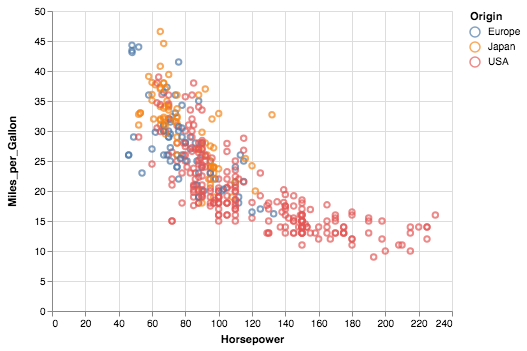

In [117]:
# Boilerplate.
import altair as alt
alt.renderers.enable('notebook')
from vega_datasets import data
cars = data.cars()

# Render the chart.
(alt.Chart(cars)
     .mark_point()
     .encode(x='Horsepower', y='Miles_per_Gallon', color='Origin')
)

The first method call, `alt.Chart(cars)`, instantiates a new `Chart` object. Each of the functions that follows mutates the chart and returns it, allowing the function that comes afterwards to have a go at it too. The end product is the sum of all mutations that were made in the sequence.

Method chaining is somewhat similar to state machines in what it achieves, but is a technically superior pattern. It's easy to implement, doesn't require implementing new methods, and is helpful for pruning object initialization parameters (it's more "obvious" that things like titles can be set after the initial Chart object has been created). For users, it cuts down on the need for tempoarary variables, makes debugging easier (just hide one of the methods and see what changes), and generally just *feels* elegant.

## Grammars of graphics

Method chaining isn't a design feature that's novel to `altair`. The `plotnine` library implemented it first, and `ggplot` before that. Both of these libraries are re-implementations of `ggplot2` from the R programming language, a library which introduced the (broader) world to another important concept: **grammars of graphics**.

To understand the grammar of graphics we need to understand the difference between **imperartive** and **declarative** programming. In an imperative design, you program by specifying *how*: a sequence of commands for a program to execute. In a declarative design you instead describe *what* your end result should be, and it's up to program itself to determine how to get there.

Most programming APIs are imperative as a matter of course. Imperative APIs minimize **indirection**; it's easy (well, easier) for a user to tell what a program is doing. Declarative APIs, meanwhile, hide some of the details from the user. A famous example of a declarative API is SQL, the pretty-much-universial database query language. Here's an example SQL statement:

```sql
SELECT First_Name, Nickname FROM Friends WHERE Nickname LIKE '%brain%';
```

Notice how this statement *almost* looks like an English sentence. It describes what you would like to do, without specifying how you ought to do it.

Declarative APIs can be used to build a layer of abstraction into a system. SQL's declarative style is designed to abstract away database access. A grammar of graphics, meanwhile, is a declarative API meant to abstract away the particularities of plotting.

As its second major innovation, Altair goes and implements a declarative API, utilizing a grammar of graphics. Take a look again at the example chart, paying attention to what the functions that we are actually calling here are doing:

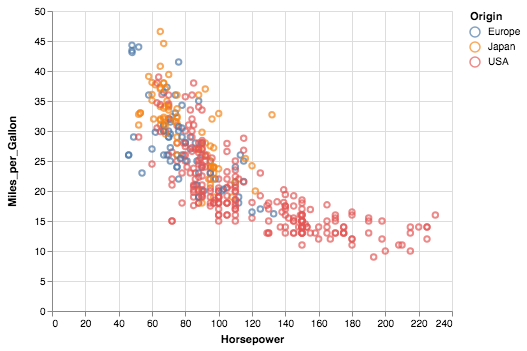

In [118]:
(alt.Chart(cars)
     .mark_point()
     .encode(x='Horsepower', y='Miles_per_Gallon', color='Origin')
)

After initializing the `Chart` object, this code sample approaches plotting in two steps. First, we specify (`mark_point`) that we want to use a point [glyph](https://en.wikipedia.org/wiki/Glyph). Then, we bind (`encode`) the data to the plot.

In the first section of this post we talked about abstraction stacks, and how most libraries have a "chart" abstraction layer that sits on top of a "geometry" layer. A grammar of graphics is an abstraction layer that essentially replaces the "chart" layer. We still have raw shapes underneath, but now instead of pushing data into a chart directly, we think about the marks and data encoding that we will use.

In the ubiqituous chart-based libraries, charts are first-class citizen. In a grammar of graphics based library, data replaces the chart a as the first class citizen; our workflow instead revolves around things we "do" with the data.

The "grammar" is grammar of graphics is literal: it invokes new concepts, like glyphs and visual encodings, to understand and master. Many of these concepts are the invention of academia, which has always considered data visualization less as an objective-directed task and more as a set of encoded relationships betweens different aspects of data pushed onto a page or a screen. These ideas take more work to grasp and use effectively than charts.

There are a couple of reasons why this overhead may be worth it. The more practical benefit is that what you lose in simplicity, you gain in flexibility. Probably the most powerful demonstration of this benefit is faceting. Faceting is when we create multiple plots, each one focusing on a specific sub-group of the data. To facet in `matplotlib` we have to frame the scene and subselect the data ourselves:

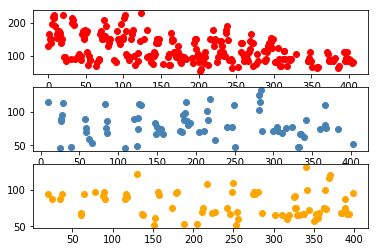

In [144]:
fig, axarr = plt.subplots(3)
axarr[0].plot(cars.query("Origin == 'USA'").Horsepower, 'o', color='red')
axarr[1].plot(cars.query("Origin == 'Europe'").Horsepower, 'o', color='steelblue')
axarr[2].plot(cars.query("Origin == 'Japan'").Horsepower, 'o', color='orange')

In `altair` we add one line. Done!

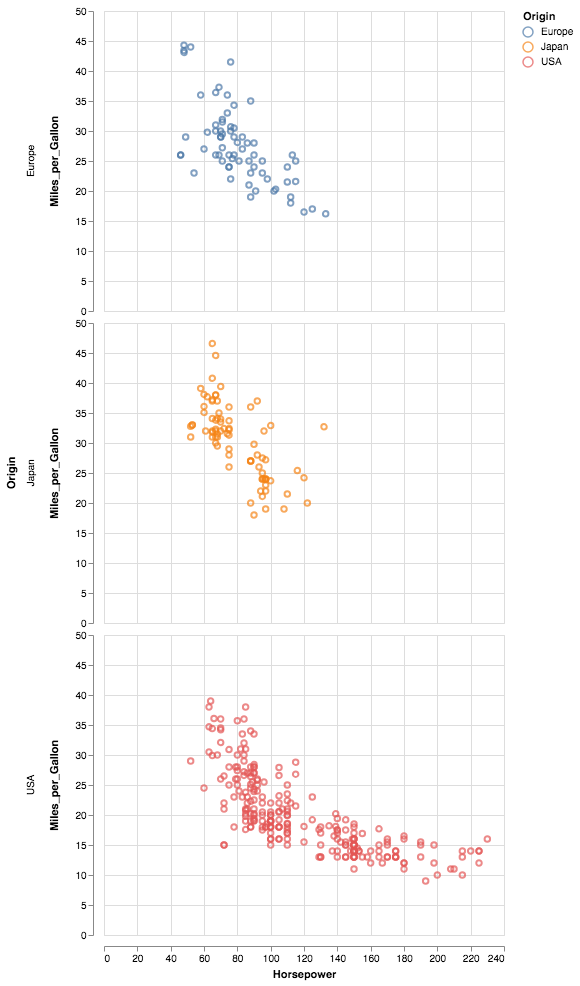

In [146]:
(alt.Chart(cars)
     .mark_point()
     .encode(x='Horsepower', y='Miles_per_Gallon', color='Origin')
     .facet('Origin')
)

To be fair, `matplotlib` is particularly bad at this. The `seaborn` library provides a `FacetGrid` object that makes faceting like this significantly easier. But that still requires creating and reasoning about a new object. Altair's grammar of graphics looks trivial by comparison!

The other benefit of grammars of graphics is more theoretical. Well-designed grammars directly enable deconstructing familiar templates, like bar charts, into core ideas; and then mixing those ideas with others to create novel data visualizations.

Grammars of graphics have not exactly taken over the world yet. If you are not particularly invested in the data product you are building, the visualization templates provided by the Chart abstraction are still the simplest, easiest way to get work done. Nevertheless, even if you will not use these libraries in your day to day work, I strongly encourage you to try out `altair` (or a similar grammar-based library, like `plotnine`). This is a great API idea that really frames what makes data visualization tick.

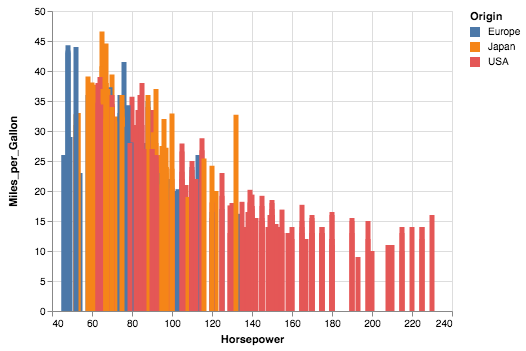

In [130]:
(alt.Chart(cars)
     .mark_bar()
     .encode(x='Horsepower', y='Miles_per_Gallon', color='Origin')
)

## Conclusions

In this post we discussed the two major data visualization user tasks and how they differ from one another. Then we saw four of the most important interface design ideas percolating through the data visualization today. This is obviously far from comprehensive, and there are tons more ideas out there, like:

* Literate programming and widget interactivity, courtesy of `bqplot` and `holoviews`.
* Intrinsic interactivity, featured in `mpld3`, `bokeh`, `altair`, `plotly`, and others.
* User-chosen abstraction layers, as in `holoviews`.
* Online sync, as in `plotly`.

We've covered what I think are some of the most influential ideas right now here, but there's certainly enough out there to write another blog post or three. In the meantime, keep visualizing!